# IMPORT LIBRARIES

In [1]:
# Timing and System Utilities
import time

# Basic Data Handling
import numpy as np
import pandas as pd

# Machine Learning: Model Building and Evaluation
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import ClassifierChain
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, average_precision_score

# Bayesian Optimization
from skopt import gp_minimize
from skopt import space
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args
from skopt.callbacks import DeltaYStopper

# Natural Language Processing
import spacy
from sentence_transformers import SentenceTransformer

# Deep Learning
import tensorflow as tf
from tensorflow.keras import backend as K
from keras.backend import clear_session
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, LSTM, Bidirectional, GlobalAveragePooling1D, Reshape, Conv1D, MaxPooling1D, Embedding
from keras.optimizers import Adam
from keras.metrics import AUC, Recall
from tensorflow.keras.regularizers import l2

# Visualization
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

# GPU Configuration Check
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    print("Found a GPU with the name:", gpus[0])
else:
    print("Failed to detect a GPU.")

Found a GPU with the name: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
# Load the English tokenizer, tagger, parser, NER and word vectors
nlp = spacy.load("en_core_web_sm")

# DATA PREPARATION

In [3]:
%%time

# Load training data
df_train = pd.read_csv('Data/train.csv', index_col='id')
# Load test data
df_test = pd.read_csv('Data/test.csv', index_col='id')
# Load sample labels
df_sample = pd.read_csv('Data/test_labels.csv', index_col='id')

CPU times: total: 1.58 s
Wall time: 1.73 s


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159571 entries, 0000997932d777bf to fff46fc426af1f9a
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   comment_text   159571 non-null  object
 1   toxic          159571 non-null  int64 
 2   severe_toxic   159571 non-null  int64 
 3   obscene        159571 non-null  int64 
 4   threat         159571 non-null  int64 
 5   insult         159571 non-null  int64 
 6   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 9.7+ MB


In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 153164 entries, 00001cee341fdb12 to ffffce3fb183ee80
Data columns (total 1 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   comment_text  153164 non-null  object
dtypes: object(1)
memory usage: 2.3+ MB


In [6]:
df_train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


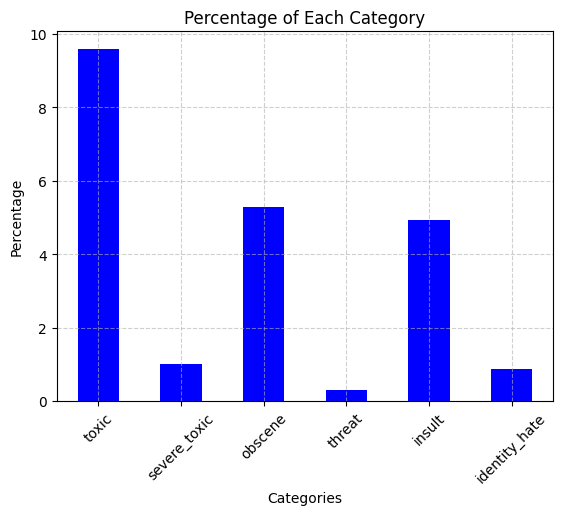

CPU times: total: 93.8 ms
Wall time: 239 ms


In [7]:
%%time

def create_bar_chart_percentage(df):
    """
    Creates a bar chart to display the percentage of each categorical label in the dataframe.

    Parameters:
        df: A pandas DataFrame containing the columns with categorical data.
    """
    # Calculate percentages of categories
    percentages = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].mean() * 100
    
    # Plotting the percentages as a bar chart
    percentages.plot(kind='bar', color='blue')
    plt.title('Percentage of Each Category')
    plt.xlabel('Categories')
    plt.ylabel('Percentage')
    plt.grid(True)
    plt.grid(True, linestyle='--', alpha=0.6)  # Adding grid lines for better readability
    plt.xticks(rotation=45)  # Rotate category labels for better visibility
    plt.show()

create_bar_chart_percentage(df_train)

The dataset is highly unbalanced, presenting a significant challenge that needs addressing. Moreover, processing 159,000 samples is currently not feasible on our local machine due to efficiency constraints. Therefore, we will eliminate columns that lack any toxicity labels to streamline the dataset for more manageable processing resulting more balanced data.

In [8]:
# Extracting target columns
target_columns = list(df_train.columns.drop('comment_text'))
target_columns

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [9]:
"""
Balances the dataset by undersampling non-toxic entries and combining them with toxic entries.
"""
# Filter non-toxic entries and sample a fraction of them
df_train_non_toxic = df_train[df_train[target_columns].max(axis=1)==0]
df_train_non_toxic = df_train_non_toxic.sample(frac=0.10)

# Filter toxic entries
df_train_toxic = df_train[df_train[target_columns].max(axis=1)==1]

# Concatenate toxic and non-toxic samples to form a balanced dataset
df_train_balanced = pd.concat([df_train_toxic, df_train_non_toxic])

In [10]:
df_train_balanced.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0
0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0
001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0


In [11]:
df_train_balanced.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,30560.000000,30560.000000,30560.000000,30560.000000,30560.000000,30560.000000
mean,0.500458,0.052192,0.276473,0.015641,0.257755,0.045975
std,0.500008,0.222418,0.447261,0.124086,0.437406,0.209435
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


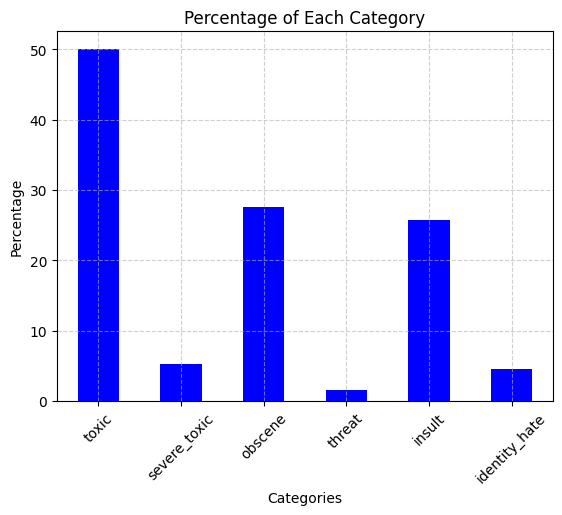

In [12]:
create_bar_chart_percentage(df_train_balanced)

The dataset is now more balanced compared to the previous version, and it includes fewer data points. This reduction not only enhances data balance but also boosts execution performance on the machine.

# DATA PREPROCESSING AND EDA

In [13]:
%%time

# Normalize texts and extract token-related information in one pass using nlp.pipe
def normalize_and_extract_info(texts):
    """
    Normalizes texts and extracts various token-related information using spaCy's efficient batch processing.

    Parameters:
        texts (Iterable[str]): An iterable of text strings to process.

    Returns:
        tuple: A tuple containing lists of normalized texts, tokens, token counts, sentence counts, and lemmas.
    """
    output = []                # Normalized texts
    tokens_list = []           # Tokens for each text
    number_of_tokens = []      # Number of tokens in each text
    number_of_sentences = []   # Number of sentences in each text
    lemmas_list = []           # Lemmas useful for word clouds

    # Using nlp.pipe for efficient batch processing
    for doc in nlp.pipe(texts, batch_size=50):  # Adjust batch_size for faster execution
        # Extract lemmatized tokens excluding punctuation, spaces, digits, URLs, and stopwords
        lemmatized = [token.lemma_ for token in doc if not token.is_punct and not token.is_space and not token.is_digit and not token.like_url and not token.is_stop]
        output.append(' '.join(lemmatized))

        # Token and sentence information
        tokens = [token for token in doc if not token.is_punct and not token.is_space]
        tokens_list.append(tokens)
        number_of_tokens.append(len(tokens))
        number_of_sentences.append(len(list(doc.sents)))

        # Lowercased lemmas, excluding stopwords
        lemmas_list.append([token.lemma_.lower() for token in doc if token.is_alpha and not token.is_stop])

    return output, tokens_list, number_of_tokens, number_of_sentences, lemmas_list

# Process texts and extract features
(df_train_balanced['comment_text_normalized'],
 df_train_balanced['tokens'],
 df_train_balanced['number_of_tokens'],
 df_train_balanced['number_of_sentences'],
 df_train_balanced['lemmas']) = normalize_and_extract_info(df_train_balanced['comment_text'])

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x0000025D06EAF7C0>>
Traceback (most recent call last):
  File "C:\Users\tolga\anaconda3\envs\my_env\lib\site-packages\ipykernel\ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


CPU times: total: 3min 17s
Wall time: 3min 33s


In [14]:
%%time

# Calculate total tokens and sentences per class for visualization
def calculate_totals(df, column):
    # Multiplying each target column by the count column and summing the results
    return {col: (df[col] * df[column]).sum() for col in target_columns}

# Calculate total tokens and sentences per class
total_tokens_per_class = pd.DataFrame(list(calculate_totals(df_train_balanced, 'number_of_tokens').items()), columns=['Class', 'Total_Tokens'])
total_sentences_per_class = pd.DataFrame(list(calculate_totals(df_train_balanced, 'number_of_sentences').items()), columns=['Class', 'Total_Sentences'])

CPU times: total: 0 ns
Wall time: 12.3 ms


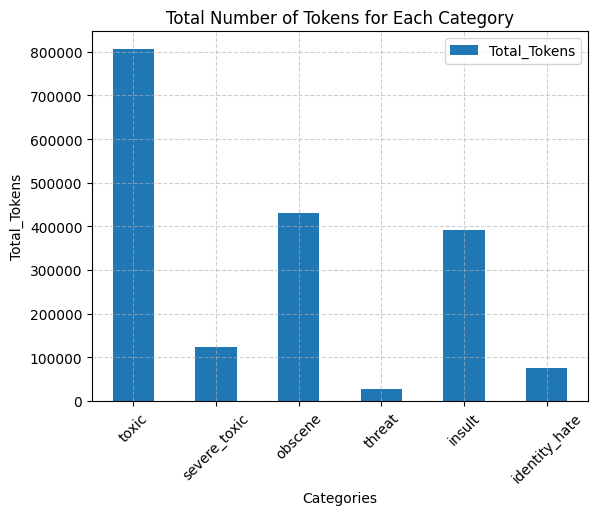

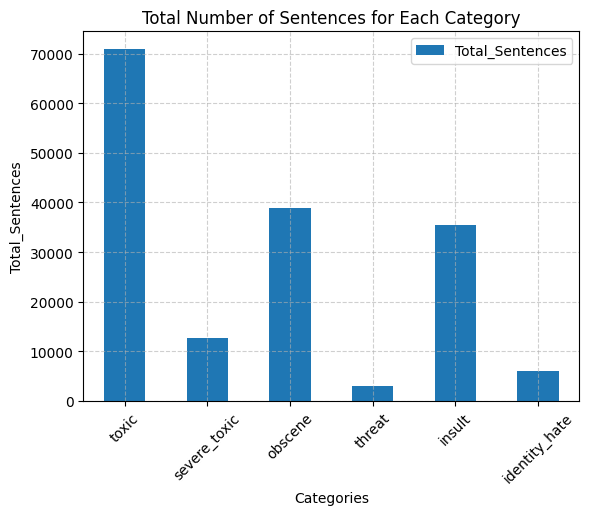

In [15]:
def plot_totals(df, title, y_label):
    """
    Plots a bar chart of totals (e.g., tokens, sentences) for each category in the DataFrame.

    Parameters:
        df (DataFrame): The DataFrame containing the totals and categories.
        title (str): The title of the plot.
        y_label (str): The label for the y-axis, representing the type of total being plotted.
    """
    # Generate a bar plot with category names on the x-axis and totals on the y-axis
    df.plot(kind='bar', x='Class', y=y_label)
    plt.title(title)
    plt.xlabel('Categories')
    plt.ylabel(y_label)
    plt.grid(True, linestyle='--', alpha=0.6)  # Adding grid lines for better readability
    plt.xticks(rotation=45)  # Rotate category labels for better visibility
    plt.show()

# Plot tokens and sentences by categories
plot_totals(total_tokens_per_class, 'Total Number of Tokens for Each Category', 'Total_Tokens')
plot_totals(total_sentences_per_class, 'Total Number of Sentences for Each Category', 'Total_Sentences')

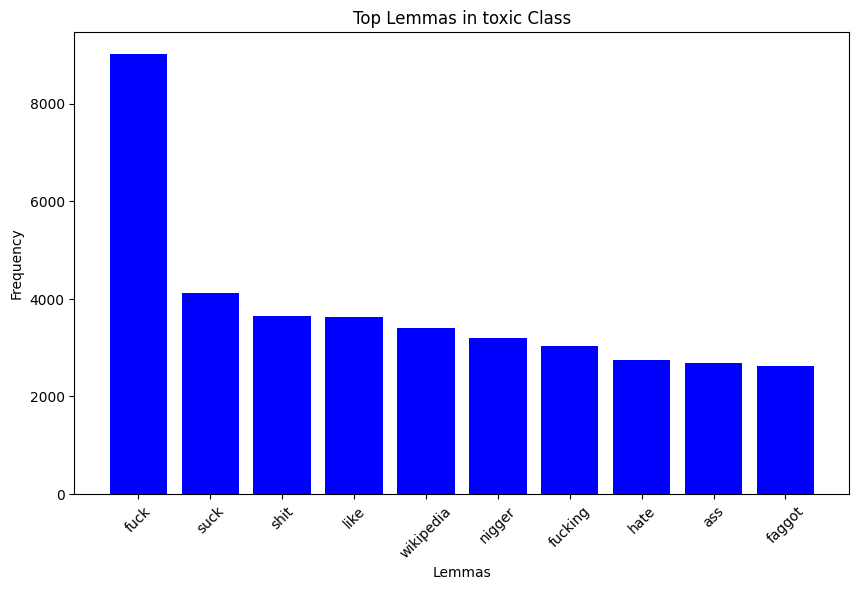

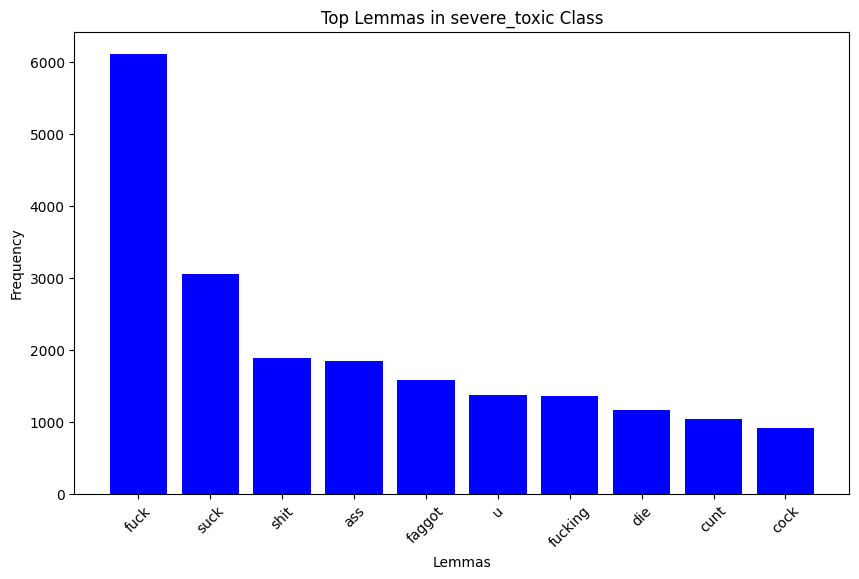

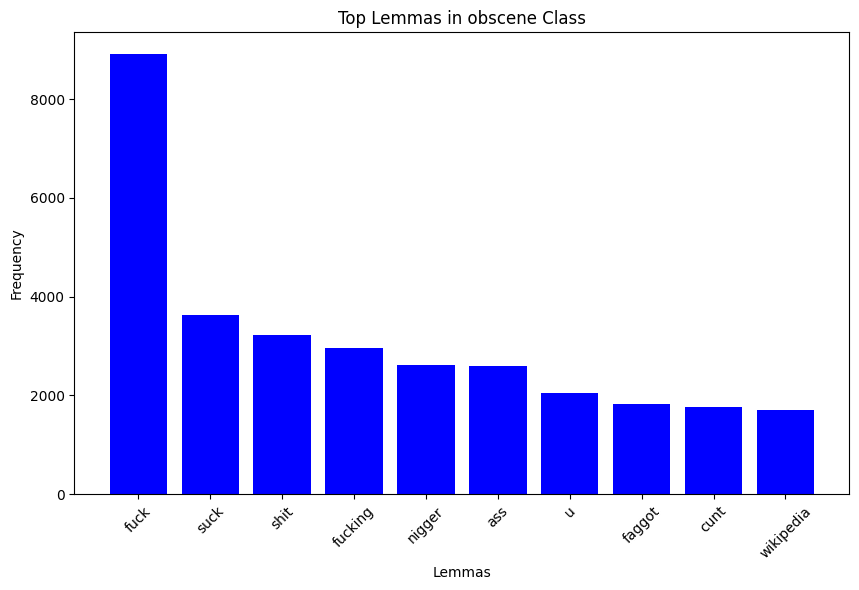

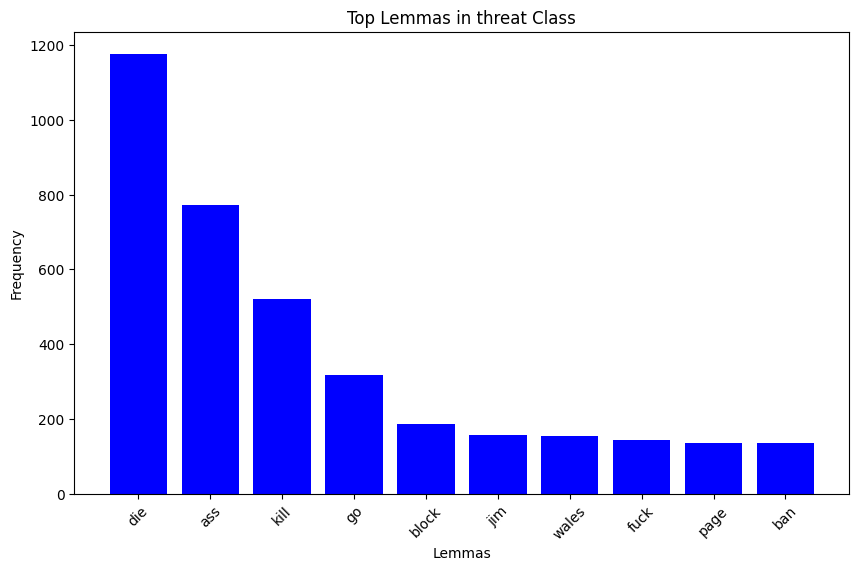

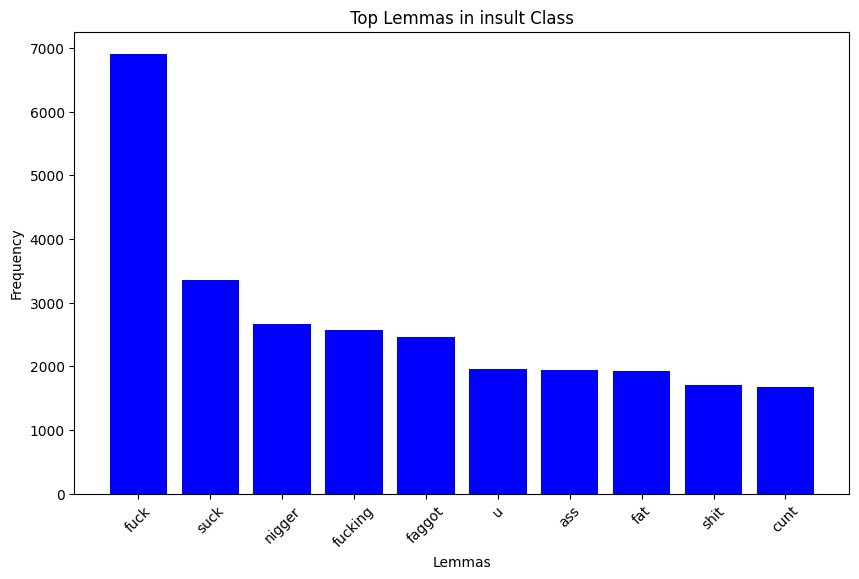

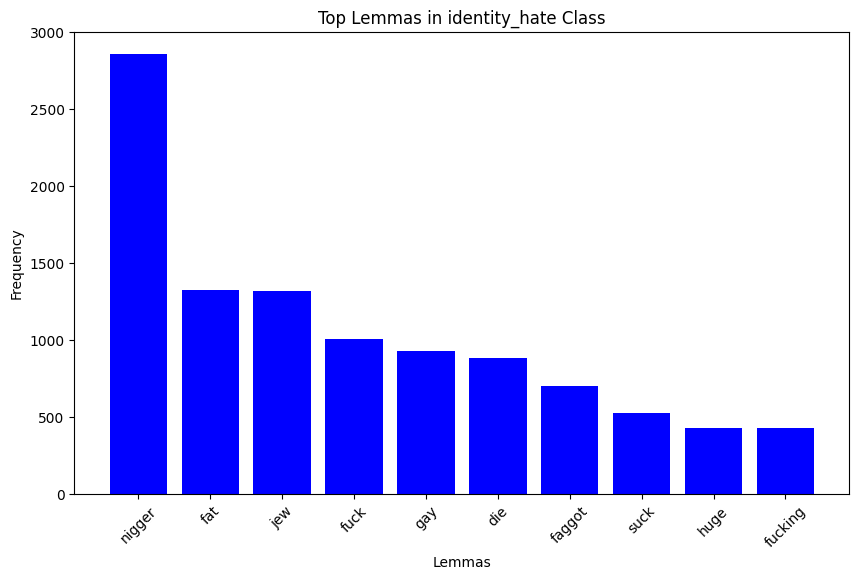

In [16]:
# Generate and plot word clouds and lemma frequency bar charts
def plot_lemmas(df, top_n=10):
    """
    Generates and plots frequency bar charts for the top N lemmas in each specified class within the dataframe.

    Parameters:
        df (DataFrame): The DataFrame containing the lemmas.
        top_n (int): The number of top lemmas to display in the bar chart.

    Notes:
        Each class in the dataset is assumed to be binary (0 or 1), and 'lemmas' should be a column containing lists of lemmas.
    """
    for class_ in target_columns:
        # Filter the dataframe for the current class
        class_df = df[df[class_] == 1]
        
        # Flatten the list of lists of lemmas and count occurrences
        all_lemmas = [lemma for sublist in class_df['lemmas'] for lemma in sublist]
        lemma_counts = Counter(all_lemmas)

        # Retrieve the most common lemmas and their counts
        top_lemmas = lemma_counts.most_common(top_n)

        # Plotting lemmas
        lemmas, counts = zip(*top_lemmas)
        plt.figure(figsize=(10, 6))
        plt.bar(lemmas, counts, color='blue')
        plt.xlabel('Lemmas')
        plt.ylabel('Frequency')
        plt.title(f'Top Lemmas in {class_} Class')
        plt.xticks(rotation=45) # Rotate the x-axis labels for better readability
        plt.show()

plot_lemmas(df_train_balanced)

Despite the occurrence of identical words across various classes, the frequencies with which these words appear can significantly differ.

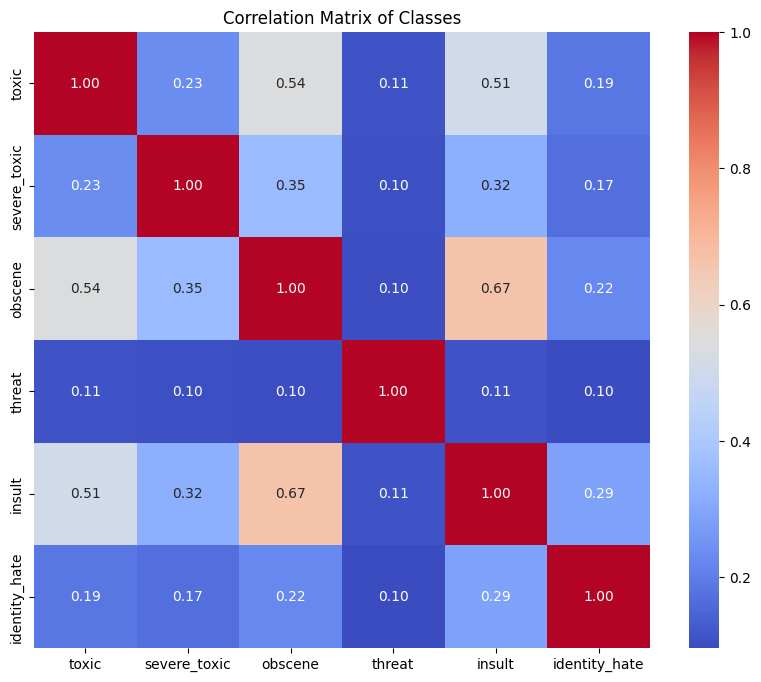

In [17]:
# Calculate the correlation matrix
correlation_matrix = df_train_balanced[target_columns].corr()

# Visualize the correlation matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Correlation Matrix of Classes')
plt.show()

Several classes exhibit strong correlations with each other. Therefore, it is essential to take these correlations into account when developing predictive models to ensure their accuracy and effectiveness.

# FEATURE EXTRACTION

In [18]:
%%time

# Initialize the TF-IDF Vectorizer with specified n-gram range and maximum features
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=5000)

# Fit the vectorizer to the text data and transform it into TF-IDF features
X_train_Tfidf = vectorizer.fit_transform(df_train_balanced['comment_text_normalized'])

CPU times: total: 4.69 s
Wall time: 4.92 s


In [19]:
display(vectorizer.get_params())

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 5000,
 'min_df': 1,
 'ngram_range': (1, 3),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [20]:
%%time
# Initialize the Sentence DistilBERT model for text embeddings
bert_model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')

# Encode the text data to get DistilBERT embeddings
X_train_bert = bert_model.encode(df_train_balanced['comment_text_normalized'].tolist(), batch_size=32, show_progress_bar=True)

Batches:   0%|          | 0/955 [00:00<?, ?it/s]

CPU times: total: 1h 37min 33s
Wall time: 10min 12s


In [21]:
sorted_targets = total_tokens_per_class.sort_values('Total_Tokens', ascending=False)['Class']
sorted_targets

0            toxic
2          obscene
4           insult
1     severe_toxic
5    identity_hate
3           threat
Name: Class, dtype: object

# MODEL DEVELOPMENT

## Train and Test Split

In [22]:
# Split the data vectorized by TF-IDF
class_array = np.array(df_train_balanced[sorted_targets])

train_ratio = 0.8
validation_ratio = 0.1
test_ratio = 0.1

X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X_train_Tfidf
                                                    , class_array
                                                    , random_state=42
                                                    , test_size=1 - train_ratio)

X_val_tf, X_test_tf, y_val_tf, y_test_tf = train_test_split(X_test_tf
                                                    , y_test_tf
                                                    , random_state=42
                                                    , test_size=test_ratio/(test_ratio + validation_ratio))

In [23]:
# Split the DistilBERT embeddings
X_train_bt, X_test_bt, y_train_bt, y_test_bt = train_test_split(X_train_bert
                                                    , class_array
                                                    , random_state=42
                                                    , test_size=1 - train_ratio)

X_val_bt, X_test_bt, y_val_bt, y_test_bt = train_test_split(X_test_bt
                                                    , y_test_bt
                                                    , random_state=42
                                                    , test_size=test_ratio/(test_ratio + validation_ratio))

## Hyperparameter Tuning with Bayesian Optimization

In [24]:
# Function to evaluate model performance
def evaluate_multi_label(y_true, y_pred, y_scores):
    """
    Calculate and return various performance metrics for a multi-label classification model.

    Args:
    y_true (array-like): True labels.
    y_pred (array-like): Predicted labels.
    y_scores (array-like): Predicted scores or probabilities for each class.

    Returns:
    dict: A dictionary containing accuracy, F1 score, recall, precision, and AUC.
    """
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred, average='macro'),
        'recall': recall_score(y_true, y_pred, average='macro'),
        'precision': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'auc': roc_auc_score(y_true, y_scores, average='macro', multi_class='ovr'),
        'auc-pr': average_precision_score(y_true, y_scores, average='macro')
    }
    return metrics

In [25]:
# Function to run hyperparameter optimization
def run_hyperparameter_optimization(X_train, y_train, X_val, y_val, search_space, model_func, n_calls=20, n_jobs=-1):
    """
    Perform hyperparameter optimization for a given model and data using Gaussian Process-based optimization.

    Args:
    X_train (array-like): Training data features.
    y_train (array-like): Training data labels.
    X_val (array-like): Testing data features.
    y_val (array-like): Testing data labels.
    search_space (list): A list of search space dimensions (e.g., Real, Integer, Categorical).
    model_func (function): A function that returns a machine learning model instance when called with hyperparameters.
    n_calls (int): Number of calls to the objective function.
    n_jobs (int): Number of parallel jobs to run for fitting. -1 means using all processors.

    Returns:
    OptimizeResult: The result of the optimization process (contains the best parameters and other optimization details).
    """
    @use_named_args(search_space)
    def objective(**params):
        # Instantiate and train the model with provided parameters
        model = model_func(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        # Check if the model has a method to predict probabilities or decision function
        if hasattr(model, "predict_proba"):
            y_scores = model.predict_proba(X_val)  # Use the probability of the positive class
        elif hasattr(model, "decision_function"):
            y_scores = model.decision_function(X_val)
        else:
            raise RuntimeError("Model must have predict_proba or decision_function method")

        # Compute the negative precision-recall AUC for minimization
        return -average_precision_score(y_val, y_scores, average='macro')

    # Run Gaussian Process minimization
    return gp_minimize(objective, search_space, n_calls=n_calls, n_jobs=n_jobs, verbose=True ,callback=[DeltaYStopper(delta=1e-4)])

### Linear SVM

In [26]:
# Define search space for SVM
svm_search_space = [
    space.Real(1e-6, 1e+1, prior='log-uniform', name='C'),
    space.Real(1e-5, 1e-1, prior='log-uniform', name='tol')
]

In [27]:
%%time

# Optimize hyperparameters for SVM with the data vectorized by TF-IDF
svm_tf_result = run_hyperparameter_optimization(X_train_tf, y_train_tf, X_val_tf, y_val_tf, svm_search_space
                                                , lambda **params: ClassifierChain(LinearSVC(**params, dual=False, random_state=42, max_iter=1000))
                                                , n_calls=40
                                               )


Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.4613
Function value obtained: -0.6467
Current minimum: -0.6467
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.5517
Function value obtained: -0.6646
Current minimum: -0.6646
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.3029
Function value obtained: -0.4280
Current minimum: -0.6646
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.7333
Function value obtained: -0.6050
Current minimum: -0.6646
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.2869
Function value obtained: -0.3425
Current minimum: -0.6646
Iteration No: 6 started. 

In [28]:
%%time

# Optimize hyperparameters for SVM with DistilBERT embeddings
svm_bt_result = run_hyperparameter_optimization(X_train_bt, y_train_bt, X_val_bt, y_val_bt, svm_search_space
                                                , lambda **params: ClassifierChain(LinearSVC(**params, dual=False, random_state=42, max_iter=1000))
                                                , n_calls=20
                                               )

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 15.3110
Function value obtained: -0.6463
Current minimum: -0.6463
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 6.2548
Function value obtained: -0.5835
Current minimum: -0.6463
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 10.8136
Function value obtained: -0.6313
Current minimum: -0.6463
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 14.7323
Function value obtained: -0.6460
Current minimum: -0.6463
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 6.8371
Function value obtained: -0.4223
Current minimum: -0.6463
Iteration No: 6 starte

In [29]:
%%time

# Retrieve the best hyperparameters from optimization results
params_tf = {'C': svm_tf_result.x[0], 'tol': svm_tf_result.x[1]}
params_bt = {'C': svm_bt_result.x[0], 'tol': svm_bt_result.x[1]}

# Initialize and train the SVM model within a Classifier Chain for TF-IDF vectorized data
svm_tf_model = ClassifierChain(LinearSVC(dual=False, random_state=42, max_iter=1000, **params_tf))
svm_tf_model.fit(X_train_tf, y_train_tf)
# Evaluate the model
metrics_tf_svm = evaluate_multi_label(y_test_tf, svm_tf_model.predict(X_test_tf), svm_tf_model.decision_function(X_test_tf))

# Initialize and train the SVM model within a Classifier Chain for the DistilBERT embeddings
svm_bt_model = ClassifierChain(LinearSVC(dual=False, random_state=42, max_iter=1000, **params_bt))
svm_bt_model.fit(X_train_bt, y_train_bt)
# Evaluate the model
metrics_bt_svm = evaluate_multi_label(y_test_bt, svm_bt_model.predict(X_test_bt), svm_bt_model.decision_function(X_test_bt))


CPU times: total: 20.5 s
Wall time: 21.1 s


### Logistic Regression

In [30]:
%%time

# Define the search space for hyperparameters
lr_search_space = [
    Real(1e-6, 1e+1, prior='log-uniform', name='C'),  # Regularization strength
    Real(1e-5, 1e-1, prior='log-uniform', name='tol'),  # Tolerance for stopping criteria
    Categorical(['liblinear', 'lbfgs', 'newton-cg'], name='solver'),  # Solvers
    Integer(500, 1500, name='max_iter')  # Maximum iterations
]

CPU times: total: 0 ns
Wall time: 3 ms


In [31]:
%%time
# Optimize hyperparameters for Logistic Regression with the data vectorized by TF-IDF
lr_tf_result = run_hyperparameter_optimization(X_train_tf, y_train_tf, X_val_tf, y_val_tf, lr_search_space
                                                , lambda **params: ClassifierChain(LogisticRegression(**params, random_state=42))
                                                , n_calls=20
                                               )


Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.2897
Function value obtained: -0.5718
Current minimum: -0.5718
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.2769
Function value obtained: -0.4438
Current minimum: -0.5718
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.3297
Function value obtained: -0.4299
Current minimum: -0.5718
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.5203
Function value obtained: -0.5638
Current minimum: -0.5718
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.4476
Function value obtained: -0.5899
Current minimum: -0.5899
Iteration No: 6 started. 

In [32]:
%%time
# Optimize hyperparameters for Logistic Regression with the DistilBERT embeddings
lr_bt_result = run_hyperparameter_optimization(X_train_bt, y_train_bt, X_val_bt, y_val_bt, lr_search_space
                                                , lambda **params: ClassifierChain(LogisticRegression(**params, random_state=42))
                                                , n_calls=20
                                               )


Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 2.7382
Function value obtained: -0.4822
Current minimum: -0.4822
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 9.6980
Function value obtained: -0.6095
Current minimum: -0.6095
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.6372
Function value obtained: -0.5740
Current minimum: -0.6095
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 7.6388
Function value obtained: -0.6523
Current minimum: -0.6523
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 10.7437
Function value obtained: -0.6250
Current minimum: -0.6523
Iteration No: 6 started.

In [33]:
%%time

# Retrieve the best hyperparameters from optimization results
params_tf_lr = {'C': lr_tf_result.x[0], 'tol': lr_tf_result.x[1], 'solver': lr_tf_result.x[2], 'max_iter': lr_tf_result.x[3]}
params_bt_lr = {'C': lr_bt_result.x[0], 'tol': lr_bt_result.x[1], 'solver': lr_bt_result.x[2], 'max_iter': lr_bt_result.x[3]}

# Initialize and train the Logistic Regression model within a Classifier Chain for TF-IDF vectorized data
lr_tf_model = ClassifierChain(LogisticRegression(dual=False, random_state=42, **params_tf_lr))
lr_tf_model.fit(X_train_tf, y_train_tf)
# Evaluate the model
metrics_tf_lr = evaluate_multi_label(y_test_tf, lr_tf_model.predict(X_test_tf), lr_tf_model.decision_function(X_test_tf))

# Initialize and train the Logistic Regression model within a Classifier Chain for the DistilBERT embeddings
lr_bt_model = ClassifierChain(LogisticRegression(dual=False, random_state=42, **params_bt_lr))
lr_bt_model.fit(X_train_bt, y_train_bt)
# Evaluate the model
metrics_bt_lr = evaluate_multi_label(y_test_bt, lr_bt_model.predict(X_test_bt), lr_bt_model.decision_function(X_test_bt))


CPU times: total: 6.38 s
Wall time: 7.75 s


### BiLSTM

In [57]:
# Define the model creation function
def create_bilstm_model(input_dim, learning_rate, num_dense_nodes, lstm_nodes, dropout_rate):
    """
    Create a Bidirectional LSTM (BiLSTM) model for sequence classification.

    Args:
    input_dim (int): The size of the input features.
    learning_rate (float): Learning rate for the optimizer.
    num_dense_nodes (int): Number of nodes in the dense layer.
    lstm_nodes (int): Number of LSTM nodes in each direction of the BiLSTM layer.
    dropout_rate (float): Dropout rate for regularization.

    Returns:
    keras.engine.sequential.Sequential: A compiled Keras model ready for training.
    """

    # Define the model architecture
    model = Sequential([
        Dense(num_dense_nodes, activation='relu', input_dim=input_dim),
        Dropout(dropout_rate),
        Reshape((num_dense_nodes, 1)), # Necessary reshape for the LSTM layer
        Bidirectional(LSTM(lstm_nodes, return_sequences=True, dropout=dropout_rate, recurrent_dropout=0.0)),
        GlobalAveragePooling1D(), # Pooling to reduce the dimensionality of the output from the LSTM layer
        Dense(num_dense_nodes, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(dropout_rate),
        # Dense(num_dense_nodes, activation='relu', kernel_regularizer=l2(0.01)),
        # Dropout(dropout_rate),
        # Dense(num_dense_nodes, activation='relu', kernel_regularizer=l2(0.01)),
        # Dropout(dropout_rate),
        Dense(6, activation='sigmoid') # Output layer for multi-label classification with 6 labels
    ])

    # Compile the model with a specified optimizer, loss function, and evaluation metrics
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy'
                  , metrics=[Recall(name='recall')])
    return model            

    # , metrics=[AUC(name='prc', curve='PR')])  

In [35]:
# Run hyperparameter optimization
def run_bilstm_optimization(X_train, y_train, X_val, y_val, dimensions, epochs=5, n_calls=10):
    """
    Run hyperparameter optimization for a BiLSTM model using Gaussian Process-based optimization.

    Args:
    X_train (array-like): Training data features.
    y_train (array-like): Training data labels.
    X_val (array-like): Validation data features.
    y_val (array-like): Validation data labels.
    dimensions (list): List of search space dimensions (e.g., Real, Integer).
    epochs (int): Number of epochs to train the model for each set of parameters.
    n_calls (int): Number of calls to the objective function.

    Returns:
    skopt.space.space.OptimizeResult: The result of the optimization process (contains the best parameters and other optimization details).
    """
    @use_named_args(dimensions=dimensions)
    def fitness(learning_rate, num_dense_nodes, lstm_nodes, dropout_rate):
        # Ensure a clean start by clearing any existing Keras session
        clear_session()

        # Create and train the BiLSTM model
        model = create_bilstm_model(X_train.shape[1], learning_rate, num_dense_nodes, lstm_nodes, dropout_rate)
        history = model.fit(X_train
                            , y_train
                            , epochs=epochs
                            , batch_size=32
                            , verbose=0
                            , validation_data=[X_val, y_val])
        
        # Evaluate the model on the test set using the PR AUC
        loss, pr_auc = model.evaluate(X_val, y_val, verbose=0)

        # Since gp_minimize minimizes the objective, return negative AUC for maximization
        return -pr_auc

    # Execute Gaussian Process-based minimization
    result = gp_minimize(fitness, dimensions, n_calls=n_calls, acq_func='EI', verbose=True, n_jobs=-1, callback=[DeltaYStopper(delta=1e-4)])
    return result

In [36]:
# Dimensions of the hyperparameter space
dimensions = [
    space.Real(1e-6, 1e-1, prior='log-uniform', name='learning_rate'),
    space.Integer(16, 128, name='num_dense_nodes'),
    space.Integer(16, 128, name='lstm_nodes'),
    space.Real(0.1, 0.5, name='dropout_rate')
]


In [37]:
def convert_sparse_matrix_to_dense(matrix):
    return matrix.toarray()

X_train_dense = convert_sparse_matrix_to_dense(X_train_tf)
X_val_dense = convert_sparse_matrix_to_dense(X_val_tf)
X_test_dense = convert_sparse_matrix_to_dense(X_test_tf)

In [38]:
'''
In this final attempt, I chose not to run the optimization functions due to their extensive time requirements.
'''

# Run optimization for TF-IDF vectorized data
# tf_bilstm_result = run_bilstm_optimization(X_train_tf_sparse, y_train_tf, X_val_tf_sparse, y_val_tf, dimensions)

'\nIn this final attempt, I chose not to run the optimization functions due to their extensive time requirements.\n'

In [39]:
'''
In this final attempt, I chose not to run the optimization functions due to their extensive time requirements.
'''
# Run optimization for the DistilBERT embeddings
# bt_bilstm_result = run_bilstm_optimization(X_train_bt, y_train_bt, X_val_bt, y_val_bt, dimensions)

'\nIn this final attempt, I chose not to run the optimization functions due to their extensive time requirements.\n'

In [58]:
# Retrieve the best parameters and retrain the model on the entire training set
# tf_best_params = tf_bilstm_result.x
tf_best_params = [0.001, 32, 32, 0.3]
tf_bilstm_model = create_bilstm_model(X_train_dense.shape[1], *tf_best_params)
tf_bilstm_model.fit(X_train_dense, y_train_tf, batch_size=32, epochs=15, validation_data=(X_val_dense, y_val_tf))

# Predict and evaluate
y_tf_bilstm_scores = tf_bilstm_model.predict(X_test_dense)
y_pred_tf_bilstm = (y_tf_bilstm_scores > 0.5).astype(int)
metrics_tf_bilstm = evaluate_multi_label(y_test_tf, y_pred_tf_bilstm, y_tf_bilstm_scores)


Epoch 1/15
764/764 [==============================] - 12s 13ms/step - loss: 0.4093 - recall: 0.4223 - val_loss: 0.2627 - val_recall: 0.6534
Epoch 2/15
764/764 [==============================] - 9s 12ms/step - loss: 0.2630 - recall: 0.6489 - val_loss: 0.2434 - val_recall: 0.6711
Epoch 3/15
764/764 [==============================] - 9s 12ms/step - loss: 0.2420 - recall: 0.6789 - val_loss: 0.2395 - val_recall: 0.6669
Epoch 4/15
764/764 [==============================] - 9s 12ms/step - loss: 0.2293 - recall: 0.6973 - val_loss: 0.2354 - val_recall: 0.7006
Epoch 5/15
764/764 [==============================] - 9s 11ms/step - loss: 0.2218 - recall: 0.7073 - val_loss: 0.2312 - val_recall: 0.6817
Epoch 6/15
764/764 [==============================] - 9s 12ms/step - loss: 0.2157 - recall: 0.7137 - val_loss: 0.2346 - val_recall: 0.6733
Epoch 7/15
764/764 [==============================] - 9s 12ms/step - loss: 0.2095 - recall: 0.7211 - val_loss: 0.2503 - val_recall: 0.5820
Epoch 8/15
764/764 [======

In [62]:
# Retrieve the best parameters and retrain the model on the entire training set
# bt_best_params = bt_bilstm_result.x
bt_best_params = [0.001, 32, 64, 0.3]
bt_bilstm_model = create_bilstm_model(X_train_bt.shape[1], *bt_best_params)
bt_bilstm_model.fit(X_train_bt, y_train_bt, batch_size=32, epochs=15, validation_data=(X_val_bt, y_val_bt))

# Predict and evaluate
y_bt_bilstm_scores = bt_bilstm_model.predict(X_test_bt)
y_pred_bt_bilstm = (y_bt_bilstm_scores > 0.5).astype(int)
metrics_bt_bilstm = evaluate_multi_label(y_test_bt, y_pred_bt_bilstm, y_bt_bilstm_scores)

Epoch 1/15
764/764 [==============================] - 12s 13ms/step - loss: 0.3530 - recall: 0.5711 - val_loss: 0.2522 - val_recall: 0.7435
Epoch 2/15
764/764 [==============================] - 9s 12ms/step - loss: 0.2519 - recall: 0.6664 - val_loss: 0.2462 - val_recall: 0.6989
Epoch 3/15
764/764 [==============================] - 9s 12ms/step - loss: 0.2420 - recall: 0.6748 - val_loss: 0.2533 - val_recall: 0.7587
Epoch 4/15
764/764 [==============================] - 10s 13ms/step - loss: 0.2373 - recall: 0.6755 - val_loss: 0.2330 - val_recall: 0.6654
Epoch 5/15
764/764 [==============================] - 8s 11ms/step - loss: 0.2330 - recall: 0.6794 - val_loss: 0.2789 - val_recall: 0.7711
Epoch 6/15
764/764 [==============================] - 9s 12ms/step - loss: 0.2298 - recall: 0.6819 - val_loss: 0.2471 - val_recall: 0.6792
Epoch 7/15
764/764 [==============================] - 10s 13ms/step - loss: 0.2291 - recall: 0.6809 - val_loss: 0.2691 - val_recall: 0.7556
Epoch 8/15
764/764 [====

# EVALUATION AND FINAL MODEL TRAINING

## EVALUATION

In [63]:
# Add a 'Model' key to each dictionary:
metrics_tf_svm['Model'] = 'TF-IDF SVM'
metrics_bt_svm['Model'] = 'BERT SVM'
metrics_tf_lr['Model'] = 'TF-IDF LR'
metrics_bt_lr['Model'] = 'BERT LR'
metrics_tf_bilstm['Model'] = 'TF-IDF BiLSTM'
metrics_bt_bilstm['Model'] = 'BERT BiLSTM'

# List of all metric dictionaries
metrics_list = [metrics_tf_svm
                , metrics_bt_svm
                , metrics_tf_lr
                , metrics_bt_lr
                , metrics_tf_bilstm
                , metrics_bt_bilstm
]

# Convert the list of dictionaries to a DataFrame
df_results = pd.DataFrame(metrics_list)

In [64]:
df_results

,accuracy,f1,recall,precision,auc,auc-pr,Model
0,0.660668,0.502042,0.437569,0.762182,0.933243,0.658394,TF-IDF SVM
1,0.637107,0.539084,0.477804,0.714138,0.923491,0.634406,BERT SVM
2,0.662304,0.549313,0.479501,0.762477,0.927199,0.644124,TF-IDF LR
3,0.634162,0.568875,0.507591,0.708788,0.927087,0.637973,BERT LR
4,0.625982,0.392359,0.384546,0.400998,0.894622,0.526034,TF-IDF BiLSTM
5,0.444045,0.375151,0.408645,0.354910,0.874334,0.513522,BERT BiLSTM


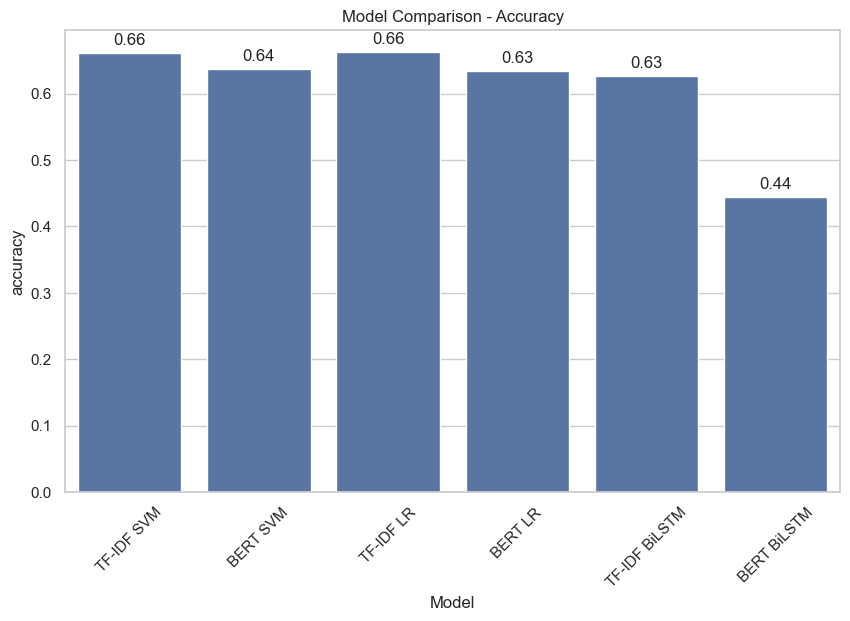

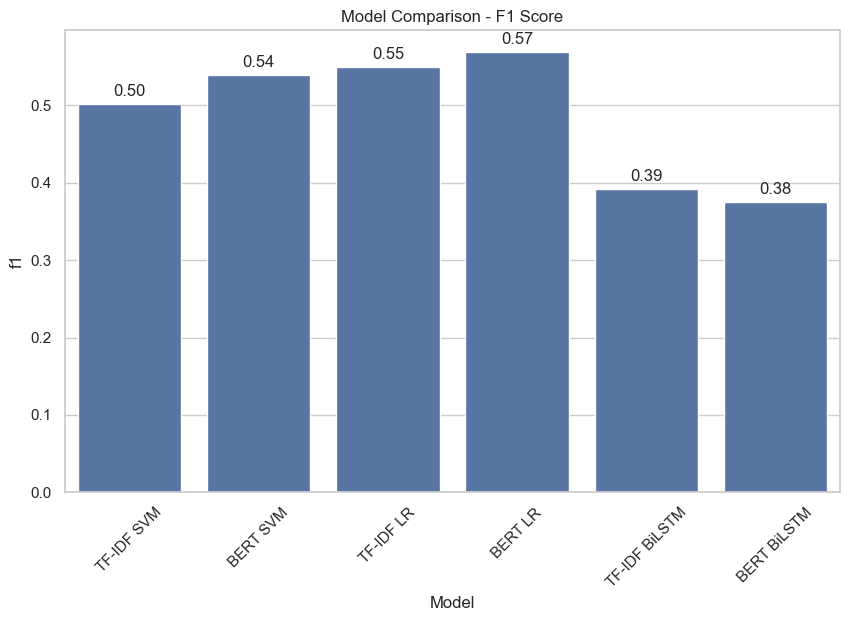

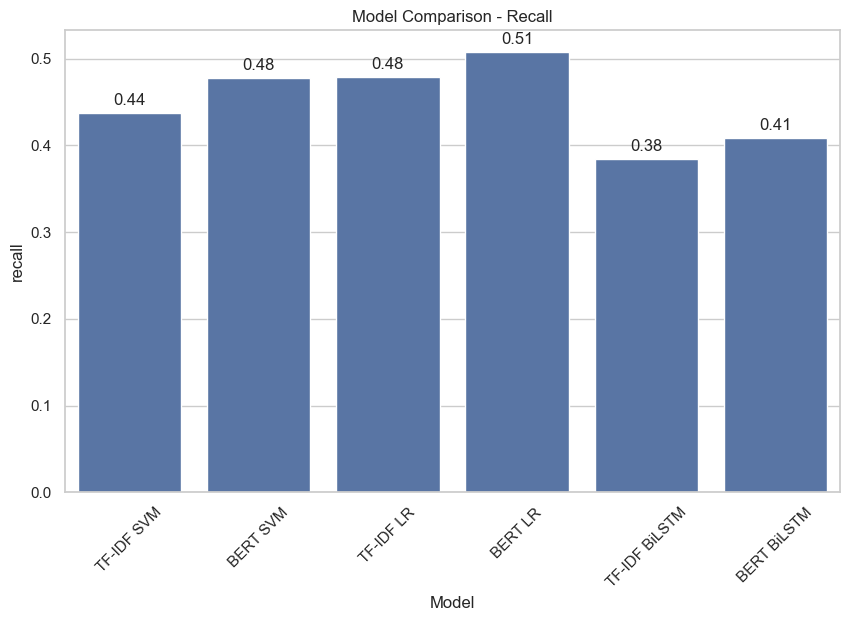

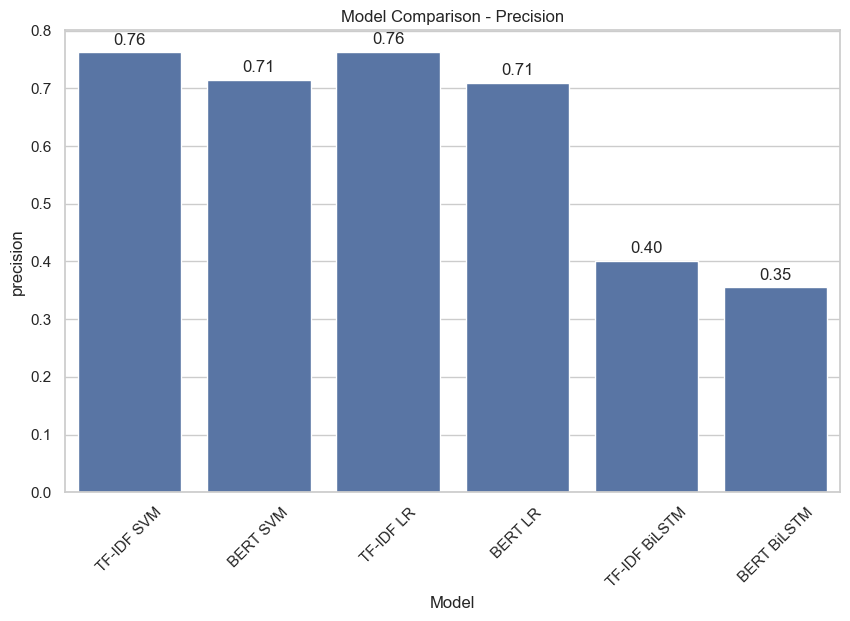

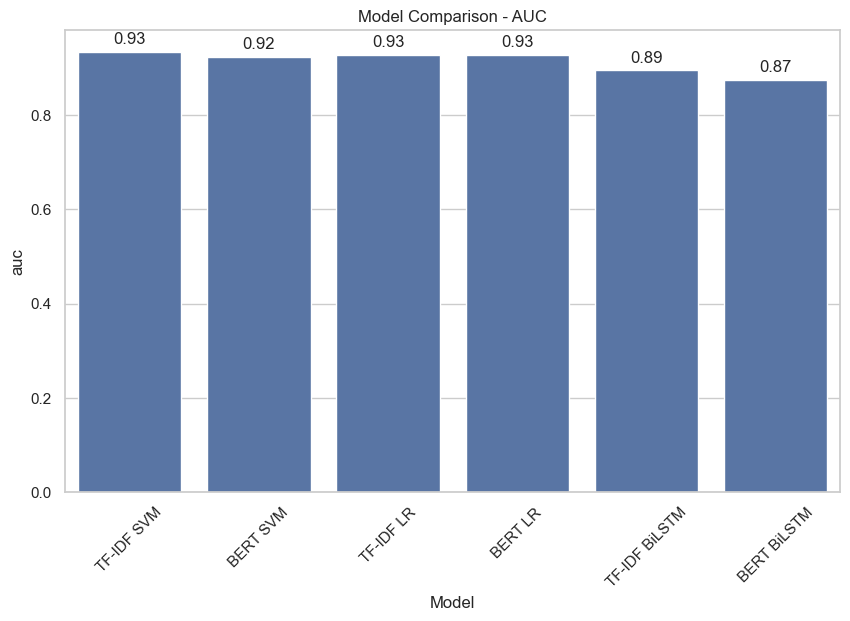

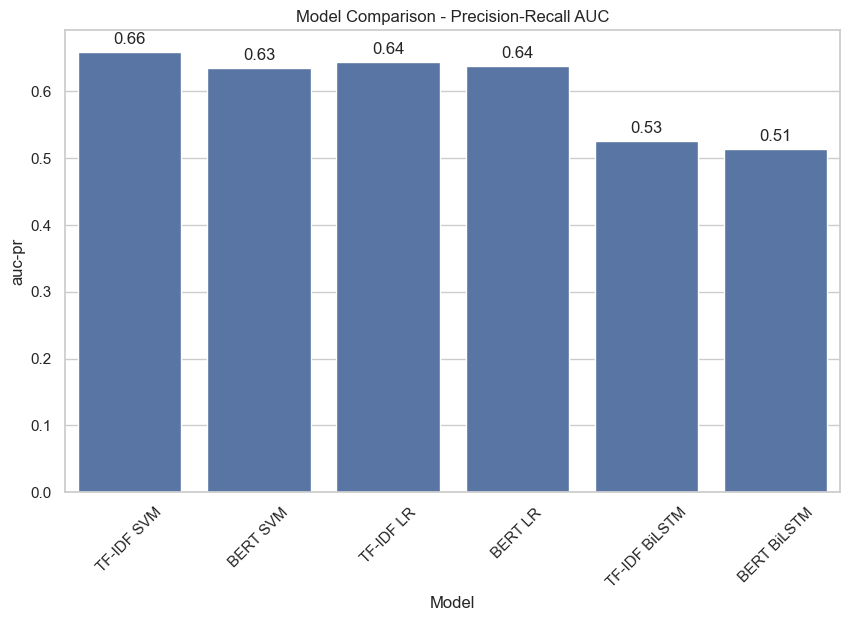

In [65]:
# Set the aesthetics for the plots
sns.set(style="whitegrid")

# Function to create a bar plot for a given metric
def plot_metric(df, metric, title):
    """
    Create a bar plot for a given metric comparing different models.

    Args:
    df (DataFrame): DataFrame containing the data to plot.
    metric (str): The name of the metric column in the DataFrame to plot.
    title (str): The title of the plot.

    """
    
    plt.figure(figsize=(10, 6))
    bar_plot = sns.barplot(x='Model', y=metric, data=df)
    bar_plot.set_title(title)

    # Adding annotations to display the metric values on the bars
    for p in bar_plot.patches:
        bar_plot.annotate(format(p.get_height(), '.2f'),  # Format the number displayed over the bars
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                          ha = 'center', 
                          va = 'center', 
                          xytext = (0, 9), 
                          textcoords = 'offset points')
    
    plt.xticks(rotation=45) # Rotate x-axis labels for better readability
    plt.show()

# Plot each metric
plot_metric(df_results, 'accuracy', 'Model Comparison - Accuracy')
plot_metric(df_results, 'f1', 'Model Comparison - F1 Score')
plot_metric(df_results, 'recall', 'Model Comparison - Recall')
plot_metric(df_results, 'precision', 'Model Comparison - Precision')
plot_metric(df_results, 'auc', 'Model Comparison - AUC')
plot_metric(df_results, 'auc-pr', 'Model Comparison - Precision-Recall AUC')

# PREDICTION

## Test Data Preparation

In [66]:
%%time

# Normalize texts
def normalize(texts):
    """
    Normalize input texts by lemmatizing and removing punctuation, spaces, digits, URLs, and stopwords.

    Args:
    texts (list of str): A list of text strings to be normalized.

    Returns:
    list of str: A list of normalized text strings.
    """
    output = []

    # Using nlp.pipe for efficient batch processing
    for doc in nlp.pipe(texts, batch_size=50):  # Adjust batch_size for faster execution
        # Extract lemmas while filtering out unwanted tokens
        lemmatized = [token.lemma_ for token in doc if not token.is_punct and not token.is_space and not token.is_digit and not token.like_url and not token.is_stop]
        output.append(' '.join(lemmatized))

    return output

# Process texts and extract features
df_test['comment_text'] = normalize(df_test['comment_text'])

CPU times: total: 16min 4s
Wall time: 17min 22s


In [67]:
# Transform the test data into TF-IDF features
X_final_test_tfidf = vectorizer.transform(df_test['comment_text'])

In [68]:
y_test_pred = lr_tf_model.predict(X_final_test_tfidf)

In [74]:
df_sample[df_sample.columns] = y_test_pred

In [76]:
df_sample.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,
00001cee341fdb12,1.0,1.0,1.0,0.0,0.0,0.0
0000247867823ef7,0.0,0.0,0.0,0.0,0.0,0.0
00013b17ad220c46,0.0,0.0,0.0,0.0,0.0,0.0
00017563c3f7919a,0.0,0.0,0.0,0.0,0.0,0.0
00017695ad8997eb,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
df_sample.to_csv('submission.csv', index=True, encoding='utf-8')